In [68]:
import os
import numpy as np
from scipy.io import loadmat
import h5py
from preproc import *
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC

In [69]:
# Specify which day's dataset to use
prefix = "/Volumes/Hippocampus/Data/picasso-misc/"
day_dir = "20181102"

In [70]:
# Get list of cells under the day directory
os.system(f"sh ~/Documents/neural_decoding/Hippocampus_Decoding/get_cells.sh {day_dir}")
cell_list = list()
with open("cell_list.txt", "r") as file:
    for line in file.readlines():
        cell_list.append(line.strip())
os.system("rm cell_list.txt")

# Load data from rplparallel.mat object, extract trial markers, time stamps and session start timestamp
rp = h5py.File(prefix + day_dir + "/session01/rplparallel.mat")
rp = rp.get('rp').get('data')
trial_markers = np.array(rp.get('markers'))
trial_timestamps = np.array(rp.get('timeStamps'))
session_start_time = np.round(np.array(rp.get('session_start_sec'))[0,0], 3)

# Load data and extract spike times from all spiketrain.mat objects
spike_times = list()
cell_labels = list()
for cell_dir in cell_list:
    spk = loadmat(prefix + day_dir + "/session01/" + cell_dir + "/spiketrain.mat")
    spk = spk.get('timestamps').flatten() # spike timestamps is loaded in as a column vector
    spk = spk / 1000 # convert spike timestamps from msec to sec
    spike_times.append(spk)
    
    cell_name = cell_dir.split('/')
    array, channel, cell = cell_name[0][6:], cell_name[1][7:], cell_name[2][5:]
    if channel[0] == '0':
        channel = channel[1:]
    cell_labels.append(f'a{array}/ch{channel}/c{cell}')

# Load data from vmpv.mat object, extract session end timestamp
pv = h5py.File(prefix + day_dir + "/session01/1vmpv.mat")
pv = pv.get('pv').get('data')
session_end_time = np.round(np.array(pv.get('rplmaxtime'))[0,0], 3)

In [71]:
# Get poster numbers from trial markers, cue phase time intervals
trial_markers = trial_markers[0,:] % 10
trial_markers = trial_markers.astype(int)
cue_intervals = trial_timestamps[0:2,:].T

# Get durations of each navigation phase
nav_timestamps = trial_timestamps[1:,:].T
nav_durations = nav_timestamps[:,1] - nav_timestamps[:,0]
nav_durations = nav_durations.astype(np.int8)

# Bin navigation phases into 1-second time bins
nav_intervals = list()
delta = 1  # Size of time bin (in seconds)
for idx, intvl in enumerate(nav_timestamps):
    nav_start, nav_end = intvl
    nav_intervals.append(np.vstack((np.arange(nav_start, nav_end - delta, delta), np.arange(nav_start + delta, nav_end, delta))).T)

# Generate time intervals for each trial
trial_intervals = np.empty_like(cue_intervals)
trial_intervals[:,0] = cue_intervals[:,1]
trial_intervals[:-1,1] = cue_intervals[1:,0]
trial_intervals[-1,1] = session_end_time

In [72]:
# Filter out trials that are too long (> 25 seconds) or have repeated goal from previous trial
good_trials = np.ones(trial_markers.shape, dtype=np.int8)
max_dur = 25  # maximum duration of trials (in seconds) to filter out
prev_goal = 0
for num, dur in enumerate(nav_durations):
    curr_goal = trial_markers[num]
    if dur > max_dur or curr_goal == prev_goal:
        good_trials[num] = 0
    prev_goal = curr_goal
trial_filt = np.where(good_trials == 1)

trial_markers = trial_markers[trial_filt]
cue_intervals = cue_intervals[trial_filt,:][0]  # not sure why it adds an extra axis
nav_durations = nav_durations[trial_filt]
new_nav_intervals = list()
for num, trial in enumerate(nav_intervals):
    if good_trials[num] == 1:
        new_nav_intervals.append(trial)
nav_intervals = new_nav_intervals
trial_intervals = trial_intervals[trial_filt]

In [73]:
# Get quantiles of trial duration distribution
nav_dur_25 = np.percentile(nav_durations, 25)
nav_dur_50 = np.median(nav_durations)
nav_dur_75 = np.percentile(nav_durations, 75)
nav_dur_min = min(nav_durations)

print(f'Percentage of trials longer than __ seconds (sample size: {nav_durations.shape[0]}):')
print(f'25%: {nav_dur_75}, 50%: {nav_dur_50}, 75%: {nav_dur_25}, min: {nav_dur_min}')

Percentage of trials longer than __ seconds (sample size: 400):
25%: 12.0, 50%: 8.5, 75%: 6.0, min: 2


In [74]:
# Bin entire session into 1-second time bins, aligned to the end of each cue phase for each trial
session_intervals = list()
for idx, intvl in enumerate(trial_intervals):
    session_intervals.append(cue_intervals[idx,:])
    nav_start, nav_end = intvl
    for time in np.arange(nav_start, nav_end - 1, 1):
        session_intervals.append(np.array([time, time + 1]))
session_intervals = np.array(session_intervals)

# Slot spikes into cue phase intervals for each trial
spikecounts_cue = spike_counts_per_observation(cue_intervals, spike_times)

# Slot spikes into navigation phase intervals
spikecounts_nav = list()
for phase in nav_intervals:
    spikecounts_nav.append(spike_counts_per_observation(phase, spike_times))

# Slot spikes into session time intervals
spikecounts_session = spike_counts_per_observation(session_intervals, spike_times)

# Get firing rate thresholds used for binning each cell across entire session
binning_stats = list()
for col in range(spikecounts_session.shape[1]):
    binning_stats.append(get_binning_stats_4(spikecounts_session[:,col]))

# Bin spike counts within each cell for cue phases
binned_spikes_cue = np.empty_like(spikecounts_cue)
for col in range(spikecounts_cue.shape[1]):
    binned_spikes_cue[:,col] = bin_firing_rates_4(spikecounts_cue[:,col], stats=binning_stats[col])

# Bin spike counts within each cell for navigation phases
binned_spikes_nav = list()
for phase in spikecounts_nav:
    binned_phase = np.empty_like(phase)
    for col in range(phase.shape[1]):
        binned_phase[:,col] = bin_firing_rates_4(phase[:,col], stats=binning_stats[col])
    binned_spikes_nav.append(binned_phase)

In [75]:
def train_test_split(X: np.array, y: np.array, split: tuple) -> tuple:
    # itr: current iteration of k-fold validation
    # way: value of k in k-fold validation
    itr, way = split
    X_train, X_test = list(), list()
    y_train, y_test = list(), list()
    for num, obs in enumerate(X):
        if num % way == itr:
            X_test.append(obs)
            y_test.append(y[num])
        else:
            X_train.append(obs)
            y_train.append(y[num])
    # Return format: X_train, X_test, y_train, y_test   
    return np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)

def prediction_accuracy(y_pred: np.array, y_actl: np.array) -> float:
    count, total = 0, y_actl.shape[0]
    for num, obs in enumerate(y_pred):
        if obs == y_actl[num]:
            count += 1
    return count / total

def confusion_matrix(y_pred: np.array, y_actl: np.array, res: np.array) -> np.array:
    for pred, actl in zip(y_pred, y_actl):
        pred, actl = pred - 1, actl - 1
        res[pred, actl] += 1
    return res

def plot_confusion_matrix(conf_mat: np.array, title: str):
    num_goals = conf_mat.shape[0]
    col_sums = np.sum(conf_mat, axis=0)
    conf_mat_prop = np.empty_like(conf_mat)
    for col, val in enumerate(col_sums):
        conf_mat_prop[:,col] = conf_mat[:,col] / val

    plt.figure()
    ax = plt.gca()
    plt.title(title)
    plt.imshow(conf_mat_prop, cmap='cool', vmin=0, vmax=1)
    plt.colorbar(label='Proportion of hits')
    plt.xticks(np.arange(num_goals), labels=np.arange(1, num_goals+1))
    plt.yticks(np.arange(num_goals), labels=np.arange(1, num_goals+1))
    plt.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
    plt.xlabel('Actual goal')
    plt.ylabel('Predicted goal')
    ax.xaxis.set_label_position('top')
    for i, row in enumerate(conf_mat):
        for j, val in enumerate(row):
            ax.text(j, i, f'{val:.0f}', ha='center', va='center', color='k')

def get_nav_timebin(nav_spikes: list, timebin: int) -> np.array:
    res = list()
    for trial in nav_spikes:
        if trial.shape[0] > timebin:
            res.append(trial[timebin,:])
    return np.array(res)

def k_fold_prediction(data, model, k_fold):
    # Unpack data
    spikes_per_trial, trial_markers, num_goals = data
    # Initialize arrays for storing results
    accuracy = np.zeros(k_fold)
    confusion_mat = np.zeros((num_goals, num_goals))
    # RUn k-fold prediction
    for k in range(k_fold):
        X_train, X_test, y_train, y_test = train_test_split(spikes_per_trial, trial_markers, (k, k_fold))
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy[k] = prediction_accuracy(y_pred, y_test)
        confusion_mat = confusion_matrix(y_pred, y_test, confusion_mat)
    return accuracy, confusion_mat


In [114]:
# Use LDA model and define important constants
model_name = 'LDA, binned'
model = LinearDiscriminantAnalysis()
# model = SVC()
num_goals = 6
k_fold = 10

# Dataset to use (binned or raw counts)
cue_input = binned_spikes_cue
nav_input = binned_spikes_nav
# cue_input = spikecounts_cue
# nav_input = spikecounts_nav

# Decoding for cue phase
cue_accuracy, cue_conf_mat = k_fold_prediction((cue_input, trial_markers, num_goals), model, k_fold)

# Store results in big array
accuracies, confusion_mats = [cue_accuracy], [cue_conf_mat]

In [115]:
# Decoding across trial
for timebin in range(0, int(nav_dur_50)):
    bin_accuracy, bin_conf_mat = k_fold_prediction((get_nav_timebin(nav_input, timebin), trial_markers, num_goals), model, k_fold)
    accuracies.append(bin_accuracy)
    confusion_mats.append(bin_conf_mat)

In [116]:
# Calculate average accuracy for each time bin
mean_accuracies = list(map(lambda arr: np.sum(arr)/arr.shape[0], accuracies))

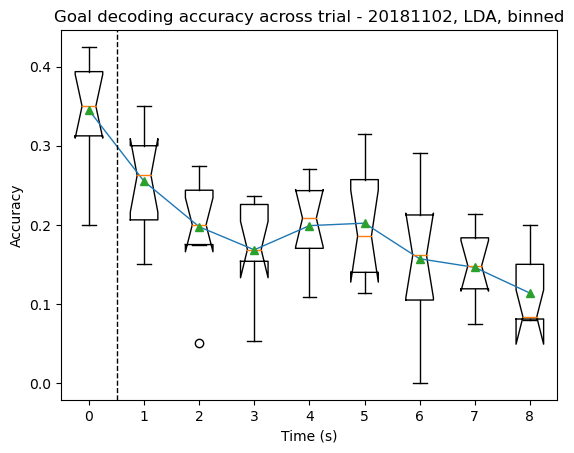

In [117]:
# Plot variance in prediciton accuracy across trial
plt.figure()
plt.title(f'Goal decoding accuracy across trial - {day_dir}, {model_name}')
plt.boxplot(accuracies, showmeans=True, notch=True)
plt.plot(np.arange(1, len(accuracies)+1), mean_accuracies, 'C0-', linewidth=1)
plt.xticks(np.arange(1, len(accuracies)+1), labels=np.arange(len(accuracies)))
plt.axvline(x=1.5, color='k', linewidth=1, linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('Accuracy')
plt.show()